# COVID-19 NL Dashboard and Models

All data is sourced from [CoronaWatchNL](https://github.com/J535D165/CoronaWatchNL), which contains open data on COVID-19 provided by the local authorities.


In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from plotnine.data import *
from sklearn.linear_model import LinearRegression

%matplotlib inline

## 1. Predict COVID-19 cases from virus-particles in sewage.

In [3]:
cases = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-geo/data-national/RIVM_NL_national.csv", parse_dates=["Datum"])
sewage = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-dashboard/data-sewage/RIVM_NL_sewage_counts.csv", parse_dates=["Datum"])

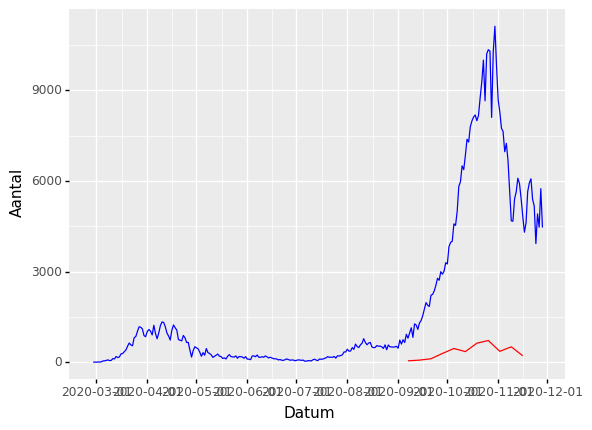

<ggplot: (138578801165)>

In [4]:
(
    ggplot(aes(x = "Datum", y = "Aantal"))
    + geom_line(data = cases[cases["Type"] == "Totaal"], color = 'blue')
    + geom_line(data = sewage, color = 'red')
)

In [4]:
sewage.head()

,Datum,Type,Aantal
0,2020-04-05,Virusdeeltjes per ml rioolwater,1430.85
1,2020-04-12,Virusdeeltjes per ml rioolwater,1386.00
2,2020-04-19,Virusdeeltjes per ml rioolwater,631.11
3,2020-04-26,Virusdeeltjes per ml rioolwater,921.63
4,2020-05-03,Virusdeeltjes per ml rioolwater,291.90


In [5]:
cases_sewage = pd.DataFrame()
cases_sewage["Cases"] = cases[cases['Datum'].isin(sewage['Datum'])][cases['Type'] == 'Totaal']['Aantal'].values
cases_sewage["Particles"] = sewage['Aantal']
cases_sewage.set_index(sewage["Datum"], inplace=True)
cases_sewage.head()

,Cases,Particles
Datum,,
2020-04-05,1224.0,1430.85
2020-04-12,1174.0,1386.00
2020-04-19,1066.0,631.11
2020-04-26,655.0,921.63
2020-05-03,335.0,291.90


In [6]:
X = cases_sewage["Particles"].values.reshape(-1, 1)
y = cases_sewage["Cases"].values.reshape(-1, 1)

reg = LinearRegression().fit(X, y)

reg.score(X, y)

0.5478408840556537

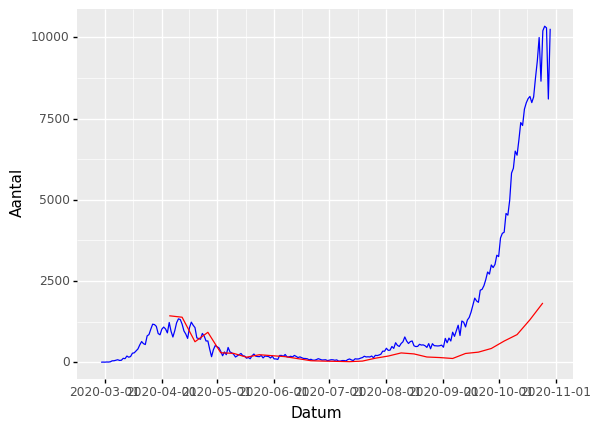

<ggplot: (76977876255)>

In [7]:
(
    ggplot(aes(x = "Datum", y = "Aantal"))
    + geom_line(data = cases[cases["Type"] == "Totaal"], color = 'blue')
    + geom_line(data = sewage, color = 'red')
    #+ geom_point(data = tests[tests["Type"] == "Totaal"])
)

In [8]:
from autoimpute.imputations import SingleImputer

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [9]:
cases_sewage2 = pd.merge(cases[cases["Type"] == "Totaal"], sewage[["Datum", "Aantal"]], on = "Datum", how = "left", suffixes=("_Personen", "_Virusdeeltjes"))
cases_sewage2.drop(columns="Type", inplace=True)
cases_sewage2 = cases_sewage2.iloc[38:]


In [41]:
sewage_imputed = SingleImputer(strategy="least squares").fit_transform(cases_sewage2.iloc[1:,1:])

In [42]:
sewage_imputed

,Aantal_Personen,AantalCumulatief,Aantal_Virusdeeltjes
39,952.0,18803.0,985.635671
40,777.0,19580.0,890.091501
41,969.0,20549.0,968.256804
42,1213.0,21762.0,1067.861739
43,1335.0,23097.0,1107.001433
...,...,...,...
241,10202.0,291254.0,1825.280000
242,10343.0,301597.0,1363.373192
243,10292.0,311889.0,1188.203170
244,8102.0,319991.0,16.270865


In [43]:
sewage_imputed["Datum"] = cases_sewage2.iloc[1:,0]

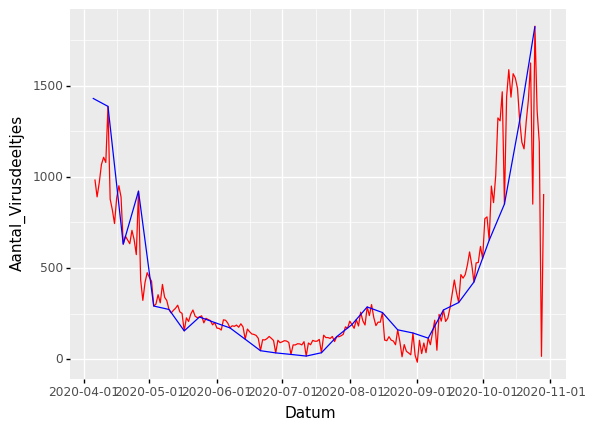

<ggplot: (76984050035)>

In [44]:
(
    ggplot(aes(x = "Datum", y = "Aantal_Virusdeeltjes"))
    + geom_line(data = sewage_imputed, color = "red")
    + geom_line(aes(y = "Aantal"), data = sewage, color = "blue")
)

In [45]:
X = sewage_imputed["Aantal_Virusdeeltjes"].values.reshape(-1, 1)
y = sewage_imputed["Aantal_Personen"].values.reshape(-1, 1)

reg2 = LinearRegression().fit(X, y)

reg2.score(X, y)

0.6471734709595888

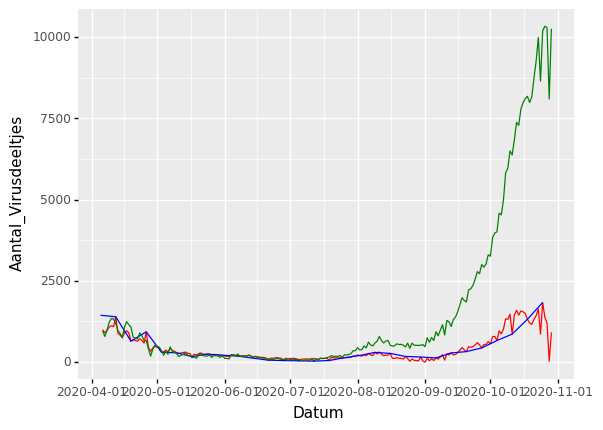

<ggplot: (76984042930)>

In [46]:
(
    ggplot(aes(x = "Datum", y = "Aantal_Virusdeeltjes"))
    + geom_line(data = sewage_imputed, color = "red")
    + geom_line(aes(y = "Aantal"), data = sewage, color = "blue")
    + geom_line(aes(y = "Aantal_Personen"), data = sewage_imputed, color = "green")
)

### To do list:
1. Idee: Corrigeren voor onvoldoende testcapaciteit tijdens de eerste golf (inschatten daadwerkelijk aantal besmetten personen).
2. Check voor MiceImputer https://pypi.org/project/autoimpute/0.12.1/

In [47]:
tests = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-misc/data-test/RIVM_NL_test_latest.csv", parse_dates=["BeginDatum", "EindDatum"])
tests["Datum"] = tests["EindDatum"]
tests = tests[["Datum", "Type", "Aantal"]]

In [48]:
tests = tests.pivot(index="Datum", columns="Type", values="Aantal")
tests["Percentage"] = tests["Positief"] / tests["Totaal"] * 100
tests.head()

Type,Positief,Totaal,Percentage
Datum,,,
2020-03-15,1529,17080,8.951991
2020-03-22,3953,21338,18.525635
2020-03-29,7232,24745,29.226106
2020-04-05,7424,29098,25.513781
2020-04-12,8391,38960,21.537474


In [62]:
suspected = pd.read_csv("https://raw.githubusercontent.com/J535D165/CoronaWatchNL/master/data-dashboard/data-contagious/RIVM_NL_contagious_estimate_normalized.csv", parse_dates=["Datum"])
suspected = suspected[suspected["Type"] == "Geschat aantal besmettelijke mensen"]
suspected.head()

,Datum,Type,Waarde
2,2020-02-17,Geschat aantal besmettelijke mensen,5.6
5,2020-02-18,Geschat aantal besmettelijke mensen,7.3
8,2020-02-19,Geschat aantal besmettelijke mensen,9.4
11,2020-02-20,Geschat aantal besmettelijke mensen,12.0
14,2020-02-21,Geschat aantal besmettelijke mensen,15.1


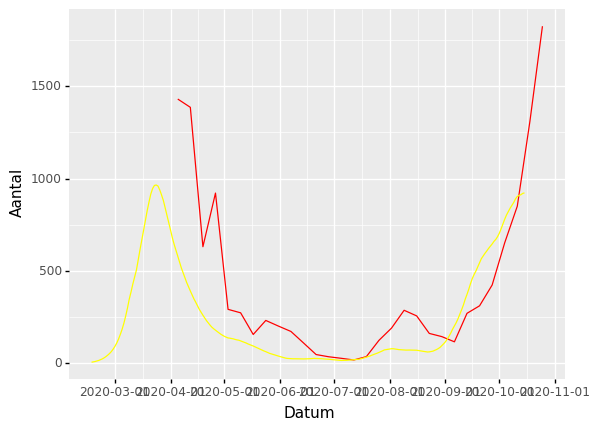

<ggplot: (76979643230)>

In [50]:
(
    ggplot(aes(x = "Datum", y = "Aantal"))
    + geom_line(data = sewage, color = "red")
    + geom_line(aes(y = "Waarde"), data = suspected, color = "yellow")
)

### Sewage data is ahead of suspected cases data, 29-10-2020

In [87]:
suspected_sewage = pd.merge(suspected[:242], sewage[["Datum", "Aantal"]], on = "Datum", how = "left")
suspected_sewage.drop(columns="Type", inplace=True)

suspected_sewage.tail(10)

,Datum,Waarde,Aantal
232,2020-10-06,820.8,NaN
233,2020-10-07,839.5,NaN
234,2020-10-08,854.6,NaN
235,2020-10-09,870.6,NaN
236,2020-10-10,890.0,NaN
237,2020-10-11,903.5,850.61
238,2020-10-12,908.7,NaN
239,2020-10-13,912.8,NaN
240,2020-10-14,919.7,NaN
241,2020-10-15,922.7,NaN


In [88]:
cs_imputed = SingleImputer(strategy="least squares").fit_transform(suspected_sewage.iloc[:,1:])

In [89]:
cs_imputed["Datum"] = suspected_sewage["Datum"]

In [90]:
cs_imputed.tail(10)

,Waarde,Aantal,Datum
232,820.8,939.813685,2020-10-06
233,839.5,957.953961,2020-10-07
234,854.6,972.601992,2020-10-08
235,870.6,988.123084,2020-10-09
236,890.0,1006.942408,2020-10-10
237,903.5,850.610000,2020-10-11
238,908.7,1025.082685,2020-10-12
239,912.8,1029.059965,2020-10-13
240,919.7,1035.753436,2020-10-14
241,922.7,1038.663640,2020-10-15


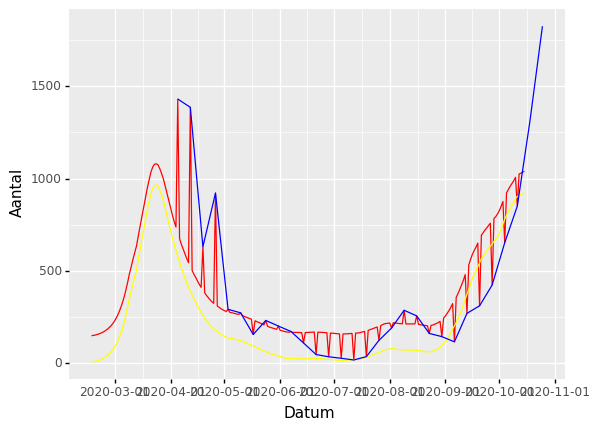

<ggplot: (76993229105)>

In [91]:
(
    ggplot(aes(x = "Datum", y = "Aantal"))
    + geom_line(data = cs_imputed, color = "red")
    + geom_line(aes(y = "Waarde"), data = cs_imputed, color = "yellow")
    + geom_line(aes(y = "Aantal"), data = sewage, color = "blue")
)

#### The model: suspected_cases = aantal_virusdeeltjes

In [92]:
X = cs_imputed["Aantal"].values.reshape(-1, 1)
y = cs_imputed["Waarde"].values.reshape(-1, 1)

reg3 = LinearRegression().fit(X, y)

reg3.score(X, y)

0.8944149758236917

R^2 = 0.9, goede fit tussen virusdeeltjes in rioolwater en het geschatte aantal besmettelijke personen
### Follow up:
Betere imputatie voor rioolwater, zie verschil rode en blauwe lijn.

### Sewage data is ahead of supected total number of cases. What is the expected amount of infected people per 100k?

In [108]:
print(sewage.tail(), "\n")
print(suspected.tail(10), "\n")
print("Suspected COVID-19 cases per 100k inhabitants on 18-10-2020:", reg3.predict([[1308.52]]))
print("Suspected COVID-19 cases per 100k inhabitants on 25-10-2020:", reg3.predict([[1825.28]]))

        Datum                             Type   Aantal
25 2020-09-27  Virusdeeltjes per ml rioolwater   423.62
26 2020-10-04  Virusdeeltjes per ml rioolwater   652.52
27 2020-10-11  Virusdeeltjes per ml rioolwater   850.61
28 2020-10-18  Virusdeeltjes per ml rioolwater  1308.52
29 2020-10-25  Virusdeeltjes per ml rioolwater  1825.28 

         Datum                                 Type  Waarde
719 2020-10-13  Geschat aantal besmettelijke mensen   912.8
722 2020-10-14  Geschat aantal besmettelijke mensen   919.7
725 2020-10-15  Geschat aantal besmettelijke mensen   922.7
728 2020-10-16  Geschat aantal besmettelijke mensen     NaN
731 2020-10-17  Geschat aantal besmettelijke mensen     NaN
734 2020-10-18  Geschat aantal besmettelijke mensen     NaN
737 2020-10-19  Geschat aantal besmettelijke mensen     NaN
740 2020-10-20  Geschat aantal besmettelijke mensen     NaN
743 2020-10-21  Geschat aantal besmettelijke mensen     NaN
746 2020-10-22  Geschat aantal besmettelijke mensen     NaN 

